In [30]:
import os
import re
import pickle
import numpy as np
import pandas as pd

# ============================================================
# Settings
# ============================================================
VEXT_MAX = 10.1
VEXT_MIN = -15
N_BINS   = 20

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")  # Strukturkürzel + Temperatur

# ============================================================
# Boltzmann-factor histogram with LOG-spaced bins in b-space
#   x = beta Vext (reduced external potential)
#   b = exp(-x)   (Boltzmann factor, physically typical)
# ============================================================
def make_boltzmann_edges_log(vmin, vmax, n_bins):
    """
    Build log-spaced bin edges in Boltzmann-factor space b = exp(-x),
    corresponding to x in [vmin, vmax].
    """
    # b-range from x-range; note exp(-x) flips ordering
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))

    # log-spaced edges (strictly positive)
    edges = np.logspace(np.log10(bmin), np.log10(bmax), n_bins + 1)
    return edges


def boltzmann_hist_logbins(arr_x, vmin, vmax, n_bins):
    """
    arr_x: reduced potential array x = beta Vext
    Returns histogram counts in log-spaced b=exp(-x) bins + edges.
    """
    # Clean + clip in x-space (same as before)
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)

    # Transform to Boltzmann factor
    b = np.exp(-x)

    # Build log-bins in b-space
    edges = make_boltzmann_edges_log(vmin, vmax, n_bins)

    # Histogram in b-space
    hist, edges = np.histogram(b, bins=edges)
    return hist, edges


# ============================================================
# Collect
# ============================================================
all_dfs = []
counter_badshape = 0

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)

    # only folders starting with "Vext_" (e.g., Vext_298)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        temp_k = float(temp)
        file_path = os.path.join(temp_path, filename)

        # Load
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # Optional shape check BEFORE clipping (same behavior as your code)
        arr_raw = np.asarray(data, dtype=np.float64).squeeze()
        arr_raw = arr_raw[np.isfinite(arr_raw)]
        if arr_raw.size != 64**3:
            counter_badshape += 1  # info/debug only

        # Boltzmann histogram (log-spaced bins in b-space)
        hist, edges = boltzmann_hist_logbins(arr_raw, VEXT_MIN, VEXT_MAX, N_BINS)

        # Store BOTH the b-space edges (optional) and x-range (for traceability)
        # Note: edges are in b-space (Boltzmann factor), not in x-space!
        entry = {
            "structure_name": struct_name,
            "temperature_kelvin": temp_k,

            # histogram counts
            **{f"bin_{i}": int(v) for i, v in enumerate(hist)},

            # store b-range that defines the histogram
            "b_min": float(edges[0]),
            "b_max": float(edges[-1]),

            # also store x-range used for clipping (useful metadata)
            "x_clip_min": float(VEXT_MIN),
            "x_clip_max": float(VEXT_MAX),
        }

        # (Optional) If you want to store edges explicitly as columns:
        # for i, e in enumerate(edges):
        #     entry[f"edge_{i}"] = float(e)

        rows.append(entry)

    if rows:
        df_temp = pd.DataFrame(rows)
        all_dfs.append(df_temp)
        print(f"{len(rows)} Strukturen verarbeitet")

# ============================================================
# Merge + Save
# ============================================================
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

print(f"\nGesamt-DataFrame mit {len(df_all)} Zeilen erstellt")
print(f"Anzahl Dateien mit unerwarteter Größe: {counter_badshape}")

out_name = "Boltzmann_allTEMP_hist_logbins_20b_FINALE.csv"
out_path = os.path.join("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/", out_name)

df_all.to_csv(out_path, index=False)
print(f"Datei gespeichert unter:\n{out_path}")



Bearbeite Temperatur-Ordner: Vext_400
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_348
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_300
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_298
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_373
245 Strukturen verarbeitet

Gesamt-DataFrame mit 1225 Zeilen erstellt
Anzahl Dateien mit unerwarteter Größe: 0
Datei gespeichert unter:
/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Boltzmann_allTEMP_hist_logbins_20b_FINALE.csv


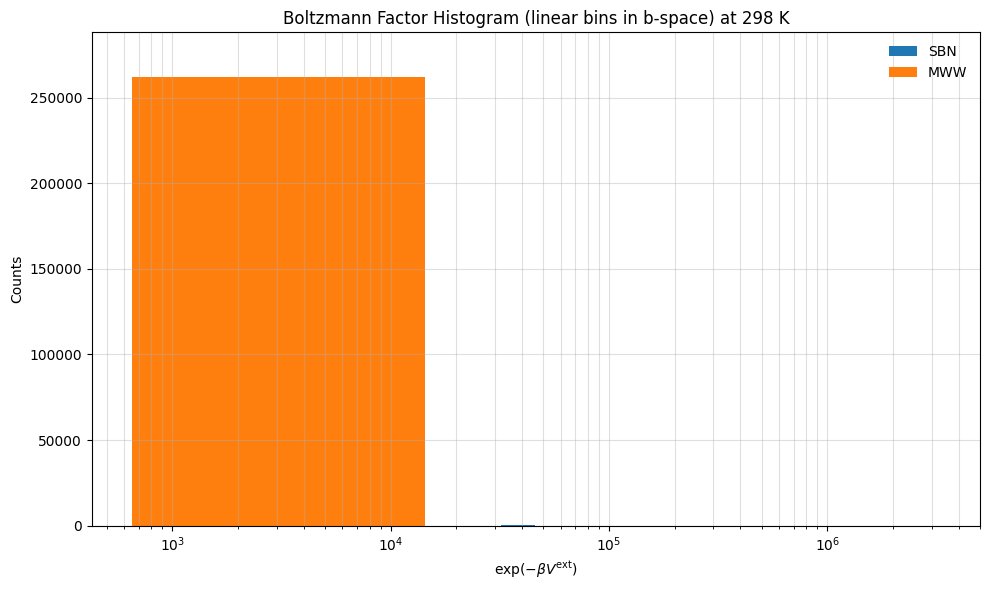

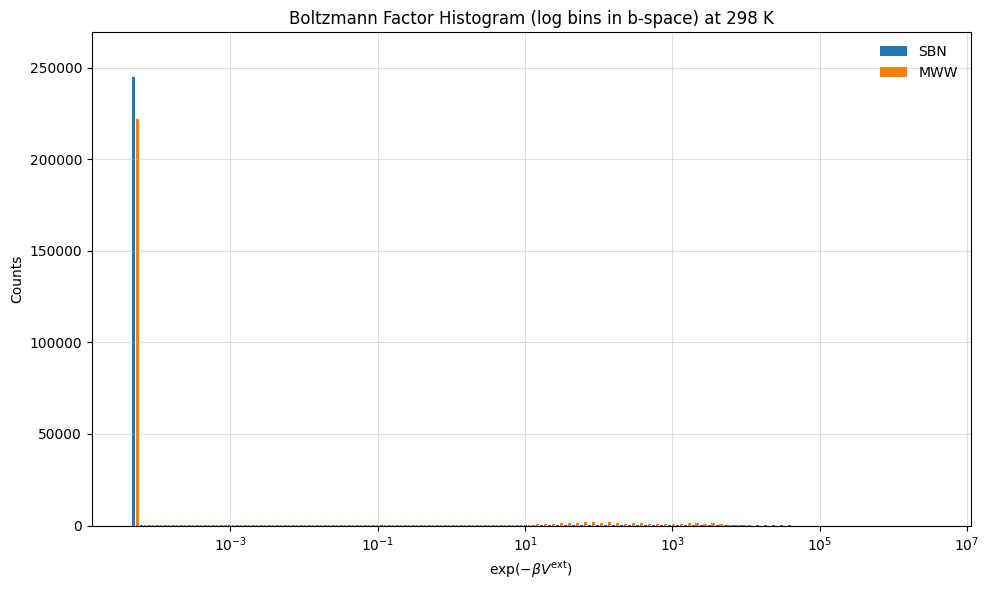

In [29]:
import pandas as pd
import pickle
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import shutil
import re
from scipy.spatial import distance

# ============================================================
# Settings
# ============================================================
N_BINS = 100
VEXT_MIN = -15
VEXT_MAX = 10

file_path1 = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/Vext_298/Vext_SBN_298.pkl"
file_path2 = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/Vext_298/Vext_MWW_298.pkl"

# ============================================================
# Helpers
# ============================================================
def load_and_clean_pkl(path, vmin, vmax):
    """Load pickled array, squeeze, remove NaN/Inf, clip to [vmin, vmax]."""
    with open(path, "rb") as f:
        arr = pickle.load(f)
    arr = np.asarray(arr, dtype=np.float64).squeeze()
    arr = arr[np.isfinite(arr)]
    arr = np.clip(arr, vmin, vmax)
    return arr


def boltzmann_factor(x, sign="minus"):
    """
    x = beta * Vext (reduced external potential)

    sign="minus": b = exp(-x)  (physically typical Boltzmann factor)
    sign="plus" : b = exp(+x)  (only if you intentionally want that)
    """
    if sign == "minus":
        return np.exp(-x)
    elif sign == "plus":
        return np.exp(x)
    else:
        raise ValueError("sign must be 'minus' or 'plus'")


def make_boltzmann_edges(vmin, vmax, n_bins, sign="minus", bins_mode="linear"):
    """
    Create bin edges in Boltzmann-factor space corresponding to x in [vmin, vmax].
    bins_mode:
      - "linear": equally spaced in b
      - "log"   : logarithmically spaced in b
    """
    # Map x-bounds to b-bounds
    if sign == "minus":
        b1, b2 = np.exp(-vmin), np.exp(-vmax)
    else:
        b1, b2 = np.exp(vmin), np.exp(vmax)

    bmin, bmax = (min(b1, b2), max(b1, b2))

    if bins_mode == "linear":
        edges = np.linspace(bmin, bmax, n_bins + 1)
    elif bins_mode == "log":
        # bmin > 0 always for exp(), so logspace is safe
        edges = np.logspace(np.log10(bmin), np.log10(bmax), n_bins + 1)
    else:
        raise ValueError("bins_mode must be 'linear' or 'log'")

    return edges


def histogram_boltzmann(x, edges, sign="minus"):
    """Histogram of Boltzmann factor b = exp(±x) using provided edges in b-space."""
    b = boltzmann_factor(x, sign=sign)
    hist, _ = np.histogram(b, bins=edges)
    return hist


def plot_histograms(hist1, hist2, edges, labels=("SBN", "MWW"), title="", use_bars=False):
    """
    Plot two histograms with shared edges.
    - Recommended: stairs (correct for variable bin widths)
    - Optional: side-by-side bars (works, but be careful with log bins)
    """
    plt.figure(figsize=(10, 6))

    if not use_bars:
        # Recommended: correct for variable bin widths (especially log-bins)
        plt.stairs(hist1, edges, label=labels[0], linewidth=2)
        plt.stairs(hist2, edges, label=labels[1], linewidth=2)
    else:
        # Side-by-side bars; supports variable bin widths
        widths = edges[1:] - edges[:-1]
        # geometric centers are best for log-scale bins
        centers = np.sqrt(edges[:-1] * edges[1:])
        # offsets as fraction of bin width
        w = 0.42 * widths
        off = 0.23 * widths
        plt.bar(centers - off, hist1, width=w, align="center", label=labels[0])
        plt.bar(centers + off, hist2, width=w, align="center", label=labels[1])

    plt.title(title)
    plt.xlabel(r"$\exp(-\beta V^{\mathrm{ext}})$")
    plt.ylabel("Counts")

    # Boltzmann factor is positive and often spans orders of magnitude
    plt.xscale("log")

    plt.ylim(0, max(hist1.max(), hist2.max()) * 1.1)
    #plt.ylim(0, 1000)
    plt.grid(True, which="both", alpha=0.4)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


# ============================================================
# Load data (x = beta * Vext)
# ============================================================
arr1 = load_and_clean_pkl(file_path1, VEXT_MIN, VEXT_MAX)
arr2 = load_and_clean_pkl(file_path2, VEXT_MIN, VEXT_MAX)

# ============================================================
# OPTION 1: Automatically (linearly) distributed bins in Boltzmann space
# ============================================================
edges_linear = make_boltzmann_edges(VEXT_MIN, VEXT_MAX, N_BINS, sign="minus", bins_mode="linear")
hist1_lin = histogram_boltzmann(arr1, edges_linear, sign="minus")
hist2_lin = histogram_boltzmann(arr2, edges_linear, sign="minus")

plot_histograms(
    hist1_lin, hist2_lin, edges_linear,
    labels=("SBN", "MWW"),
    title="Boltzmann Factor Histogram (linear bins in b-space) at 298 K",
    use_bars=True  # True if you want side-by-side bars
)

# ============================================================
# OPTION 2: Logarithmically distributed bins in Boltzmann space
# ============================================================
edges_log = make_boltzmann_edges(VEXT_MIN, VEXT_MAX, N_BINS, sign="minus", bins_mode="log")
hist1_log = histogram_boltzmann(arr1, edges_log, sign="minus")
hist2_log = histogram_boltzmann(arr2, edges_log, sign="minus")

plot_histograms(
    hist1_log, hist2_log, edges_log,
    labels=("SBN", "MWW"),
    title="Boltzmann Factor Histogram (log bins in b-space) at 298 K",
    use_bars=True  # True if you want side-by-side bars
)
